# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [27]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import json
# Import API key
from api_keys import geoapify_key

In [28]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Humidity,Cloudiness,Wind Speed,Country,Date,Max Temp Celsius
0,0,ilulissat,69.2167,-51.1000,93,75,2.06,GL,1687599345,2.16
1,1,alexandria,31.2156,29.9553,50,0,4.20,EG,1687599105,28.73
2,2,kavieng,-2.5744,150.7967,77,41,1.78,PG,1687599346,27.35
3,3,new norfolk,-42.7826,147.0587,80,100,0.88,AU,1687599348,8.43
4,4,moerai,-22.4333,-151.3333,85,100,5.50,PF,1687599349,24.86


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

:Points   [Lng,Lat]   (City,Humidity)
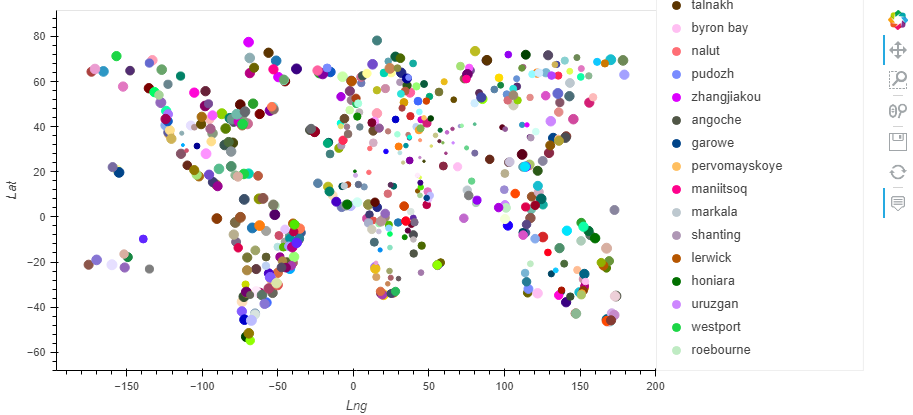

In [29]:
#adding this for github visibility
%output holomap='auto' fig='png'
#%%capture --no-display
#module 6.3 Activities for Reference
#original code wont work but w/o geo and tiles map plots without borders
#so i commented out "geo=True, "tiles="OSM""
#geoviews error

# Configure the map plot
map_1 = city_data_df.hvplot.points(
    "Lng",
    "Lat",
    size="Humidity",
    color="City",
    frame_width = 600,
    frame_height = 360,
#     geo=True,
#     tiles="OSM"
)
# Display the map
map_1

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [30]:
# Narrow down cities that fit criteria and drop any results with null values
ideal_cities = city_data_df[(city_data_df["Wind Speed"] < 2) & (city_data_df["Max Temp Celsius"]<20) & (city_data_df["Humidity"] < 60)]

# Drop any rows with null values
ideal_cities.dropna
# Display sample data
ideal_cities

,City_ID,City,Lat,Lng,Humidity,Cloudiness,Wind Speed,Country,Date,Max Temp Celsius
105,105,tarko-sale,64.9225,77.7850,50,86,1.85,RU,1687599435,10.16
132,132,toowoomba,-27.5500,151.9667,59,22,1.74,AU,1687599224,10.85
139,139,koltsovo,54.9376,83.1825,49,100,1.92,RU,1687599461,16.81
165,165,erzurum,40.0000,41.5000,42,13,1.64,TR,1687599486,17.97
185,185,esil,51.9556,66.4042,33,100,1.21,KZ,1687599507,19.16
236,236,matamba,-8.9833,33.9667,25,11,1.74,TZ,1687599555,19.88
252,252,sao miguel do araguaia,-13.2750,-50.1628,52,93,1.84,BR,1687599567,19.62
319,319,vokhma,58.9303,46.7586,48,91,1.16,RU,1687599622,19.45
535,535,omsukchan,62.5333,155.8000,41,95,1.12,RU,1687599812,18.57


### Step 3: Create a new DataFrame called `hotel_df`.

In [31]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = ideal_cities.loc[:, ("City", "Country", "Lat", "Lng", "Humidity")]
# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] =""
# Display sample data
hotel_df


,City,Country,Lat,Lng,Humidity,Hotel Name
105,tarko-sale,RU,64.9225,77.7850,50,
132,toowoomba,AU,-27.5500,151.9667,59,
139,koltsovo,RU,54.9376,83.1825,49,
165,erzurum,TR,40.0000,41.5000,42,
185,esil,KZ,51.9556,66.4042,33,
236,matamba,TZ,-8.9833,33.9667,25,
252,sao miguel do araguaia,BR,-13.2750,-50.1628,52,
319,vokhma,RU,58.9303,46.7586,48,
535,omsukchan,RU,62.5333,155.8000,41,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [32]:
# Set parameters to search for a hotel
#module 6.3 act 4 is similar

radius = 10000
#removing filters as its not static and will be defined in the loop
#filters = f"circle:{longitude},{latitude},{radius}"


params = {"apiKey":geoapify_key,
          "categories":"accommodation.hotel",
          "limit":1
         }

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    longitude = hotel_df["Lng"][index]
    latitude = hotel_df["Lat"][index]
    # 
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionary
    name_address = requests.get(base_url,params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
tarko-sale - nearest hotel: Вынгапур
toowoomba - nearest hotel: Ambassador on Ruthven
koltsovo - nearest hotel: Агат
erzurum - nearest hotel: No hotel found
esil - nearest hotel: Рахат
matamba - nearest hotel: Mama Izengo's Hotel
sao miguel do araguaia - nearest hotel: Hotel São Miguel
vokhma - nearest hotel: No hotel found
omsukchan - nearest hotel: Гостиница Зори


,City,Country,Lat,Lng,Humidity,Hotel Name
105,tarko-sale,RU,64.9225,77.7850,50,Вынгапур
132,toowoomba,AU,-27.5500,151.9667,59,Ambassador on Ruthven
139,koltsovo,RU,54.9376,83.1825,49,Агат
165,erzurum,TR,40.0000,41.5000,42,No hotel found
185,esil,KZ,51.9556,66.4042,33,Рахат
236,matamba,TZ,-8.9833,33.9667,25,Mama Izengo's Hotel
252,sao miguel do araguaia,BR,-13.2750,-50.1628,52,Hotel São Miguel
319,vokhma,RU,58.9303,46.7586,48,No hotel found
535,omsukchan,RU,62.5333,155.8000,41,Гостиница Зори


In [33]:
import pprint

In [34]:
hotel_df.loc[index, "Hotel Name"][0]



'Г'

### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

:Points   [Lng,Lat]   (City,Humidity,Hotel Name,Country)
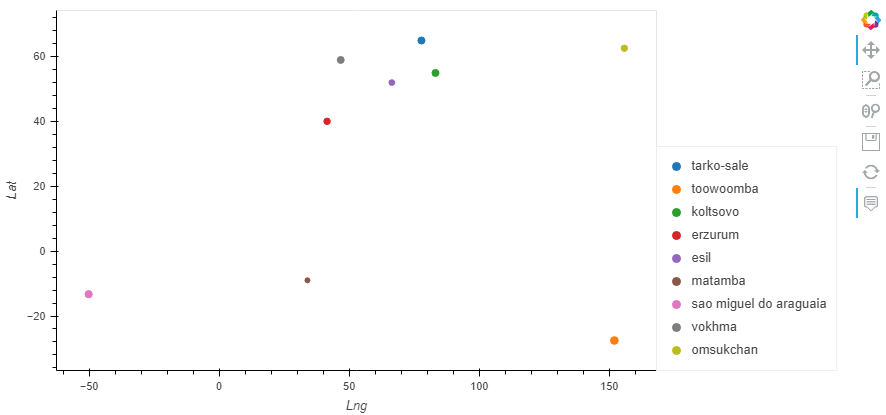

In [36]:
#adding this for github visibility
%output holomap='auto' fig='png'
#%%capture --no-display
# Configure the map plot
map_final = hotel_df.hvplot.points(
    "Lng",
    "Lat",
    size="Humidity",
    color="City",
    frame_width = 600,
    frame_height = 360,
    hover_cols=["Hotel Name","Country"]
#     geo=True,
#     tiles="OSM"
)
# Display the map
#geoviews not showing country borders, issue with package downloaded
map_final